# Baseline - Train and Save Best Case

## Set Up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import json
from scipy.sparse import load_npz

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(Path.cwd().parents[2]))

from scripts.feature_extractions.opcode_freq import get_opcodes_freq_from_files
from scripts.feature_extractions.tf_idf import get_tf_idf_vector
from scripts.feature_extractions.graphs import get_graphs_stat_from_files

In [5]:
PATH = Path.cwd().parents[2]
DATA_PATH = os.path.join(PATH, 'data/external/crpwarner/merged')
SAVE_PATH = os.path.join(PATH, 'models/1_groundtruth_with_large')

## Best Binary Model by Class

### Mint

In [6]:
df = pd.read_csv(os.path.join(DATA_PATH, 'mint.csv')).set_index('address')
df.head()

,TP?
address,
0x93023F1D3525E273F291B6f76d2F5027A39BF302,1
0x2753dcE37A7eDB052a77832039bcc9aA49Ad8b25,0
0x94b7D24552933F50A5A5705C446528806dCeA381,0
0xE0b9d4146AaD6936cBfcBE4dAE47e34aAb96b093,0
0x10f6f2b97F3aB29583D9D38BaBF2994dF7220C21,1


In [7]:
y = np.array([df['TP?']]).T

In [8]:
sol_files = []

for file in list(Path(os.path.join(DATA_PATH, 'sol')).glob('*.sol')):
    if file.stem in df.index:
        sol_files.append(file)

hex_files = []

for file in list(Path(os.path.join(DATA_PATH, 'hex')).glob('*.hex')):
    if file.stem in df.index:
        hex_files.append(file)

#### TF-IDF (Source Code)

In [9]:
X, cols  = get_tf_idf_vector(sol_files)
X

  0%|          | 0/161 [00:00<?, ?it/s]

100%|██████████| 161/161 [00:00<00:00, 7467.88it/s]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 47170 stored elements and shape (161, 2000)>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##### Train Model

In [11]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

##### Evaluate Model

In [12]:
y_pred = model.predict(X_test)

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       1.00      0.59      0.74        22

    accuracy                           0.73        33
   macro avg       0.78      0.80      0.73        33
weighted avg       0.85      0.73      0.73        33



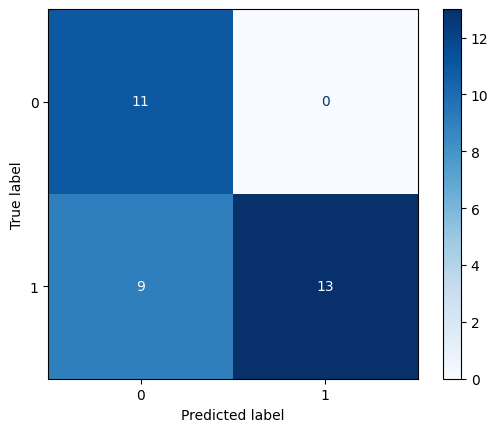

In [14]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [15]:
score = f1_score(y_test, y_pred, average='macro')
name = f"mint-f1-{score:2f}"
with open(os.path.join(SAVE_PATH, fr"{name}.pkl"), "wb") as fout:
    pickle.dump(model, fout)
print(f"Saved {name}.pkl")

Saved mint-f1-0.726267.pkl


In [16]:
with open(os.path.join(SAVE_PATH, f"{name}-feature.json"), "w") as fout:
    json.dump(list(cols), fout, indent=2)

### Leak

In [17]:
df = pd.read_csv(os.path.join(DATA_PATH, 'leak.csv')).set_index('address')
df.head()

,TP?
address,
0x93023F1D3525E273F291B6f76d2F5027A39BF302,0
0x2753dcE37A7eDB052a77832039bcc9aA49Ad8b25,0
0x94b7D24552933F50A5A5705C446528806dCeA381,0
0xE0b9d4146AaD6936cBfcBE4dAE47e34aAb96b093,0
0x10f6f2b97F3aB29583D9D38BaBF2994dF7220C21,0


In [18]:
y = np.array([df['TP?']]).T

In [19]:
sol_files = []

for file in list(Path(os.path.join(DATA_PATH, 'sol')).glob('*.sol')):
    if file.stem in df.index:
        sol_files.append(file)

hex_files = []

for file in list(Path(os.path.join(DATA_PATH, 'hex')).glob('*.hex')):
    if file.stem in df.index:
        hex_files.append(file)

#### TF-IDF (Source Code)

In [20]:
X, cols  = get_tf_idf_vector(sol_files, 3000)
X

100%|██████████| 156/156 [00:00<00:00, 7289.16it/s]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 49442 stored elements and shape (156, 3000)>

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##### Train Model

In [22]:
model = LGBMClassifier(random_state=42)
# model = DecisionTreeClassifier()
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 65, number of negative: 59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9962
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 587
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524194 -> initscore=0.096850
[LightGBM] [Info] Start training from score 0.096850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(random_state=42)

##### Evaluate Model

In [23]:
y_pred = model.predict(X_test)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71        14
           1       0.80      0.67      0.73        18

    accuracy                           0.72        32
   macro avg       0.72      0.73      0.72        32
weighted avg       0.73      0.72      0.72        32



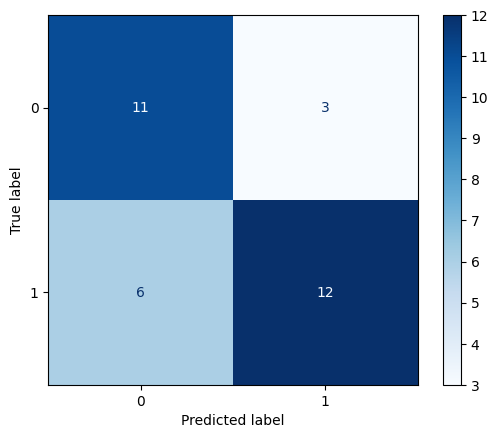

In [25]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [26]:
score = f1_score(y_test, y_pred, average='macro')
name = f"leak-f1-{score:2f}"
with open(os.path.join(SAVE_PATH, fr"{name}.pkl"), "wb") as fout:
    pickle.dump(model, fout)
print(f"Saved {name}.pkl")

Saved leak-f1-0.718475.pkl


In [27]:
with open(os.path.join(SAVE_PATH, f"{name}-feature.json"), "w") as fout:
    json.dump(list(cols), fout, indent=2)

### Limit

In [28]:
df = pd.read_csv(os.path.join(DATA_PATH, 'limit.csv')).set_index('address')
df.head()

,TP?
address,
0x93023F1D3525E273F291B6f76d2F5027A39BF302,1
0x2753dcE37A7eDB052a77832039bcc9aA49Ad8b25,1
0x94b7D24552933F50A5A5705C446528806dCeA381,0
0xE0b9d4146AaD6936cBfcBE4dAE47e34aAb96b093,0
0x10f6f2b97F3aB29583D9D38BaBF2994dF7220C21,1


In [29]:
y = np.array([df['TP?']]).T

In [30]:
sol_files = []

for file in list(Path(os.path.join(DATA_PATH, 'sol')).glob('*.sol')):
    if file.stem in df.index:
        sol_files.append(file)

hex_files = []

for file in list(Path(os.path.join(DATA_PATH, 'hex')).glob('*.hex')):
    if file.stem in df.index:
        hex_files.append(file)

#### N-Gram

In [31]:
from scripts.feature_extractions.n_grams import get_n_grams_from_files

In [32]:
from xgboost import XGBClassifier

In [33]:
X  = get_n_grams_from_files(hex_files)
cols = X.columns
X.head()

  0%|          | 0/160 [00:00<?, ?it/s]

invalid instruction: PUSH30
  4%|▍         | 6/160 [00:00<00:08, 17.63it/s]invalid instruction: PUSH32
invalid instruction: PUSH20
invalid instruction: PUSH11
  8%|▊         | 13/160 [00:00<00:04, 33.86it/s]invalid instruction: PUSH19
invalid instruction: PUSH5
invalid instruction: PUSH28
invalid instruction: PUSH29
 12%|█▏        | 19/160 [00:00<00:03, 41.44it/s]invalid instruction: PUSH30
invalid instruction: PUSH25
invalid instruction: PUSH17
invalid instruction: PUSH26
 15%|█▌        | 24/160 [00:00<00:04, 33.18it/s]invalid instruction: PUSH28
invalid instruction: PUSH29
invalid instruction: PUSH21
invalid instruction: PUSH28
 18%|█▊        | 29/160 [00:00<00:03, 36.95it/s]invalid instruction: PUSH13
invalid instruction: PUSH24
 22%|██▏       | 35/160 [00:00<00:02, 42.21it/s]invalid instruction: PUSH30
invalid instruction: PUSH16
invalid instruction: PUSH29
invalid instruction: PUSH27
invalid instruction: PUSH29
 25%|██▌       | 40/160 [00:01<00:03, 35.65it/s]invalid instruction: P

,add add,add and,add and dup,add calldataload,add calldataload push,add calldataload swap,add dup,add dup add,add dup dup,add dup mstore,...,unknown jumpdest div,unknown jumpdest dup,unknown jumpdest push,unknown jumpdest swap,unknown log,unknown push,unknown swap,unknown swap dup,unknown unknown,unknown unknown unknown
address,,,,,,,,,,,,,,,,,,,,,
0x8275ebf521dc217aa79c88132017a5bcef001dd9,0,0,0,0,0,0,6,0,6,0,...,0,2,0,0,0,0,0,0,3,0
0x292e89d5d5bdab3af2f5838c194c1983f0140b43,2,0,0,2,0,2,3,1,0,1,...,0,0,0,0,0,1,0,0,2,1
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,3,0,0,2,0,2,9,1,3,1,...,0,0,0,0,1,0,0,0,6,4
0xe1a0ce8b94c6a5e4791401086763d7bd0a6c18f5,0,0,0,7,5,1,22,2,14,0,...,0,0,0,0,0,2,0,0,0,0
0x9db8a10c7fe60d84397860b3af2e686d4f90c2b7,0,4,4,15,9,4,64,2,30,6,...,0,0,0,0,0,2,0,0,0,0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##### Train Model

In [35]:
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

##### Evaluate Model

In [36]:
y_pred = model.predict(X_test)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.84      0.88      0.86        24

    accuracy                           0.78        32
   macro avg       0.71      0.69      0.70        32
weighted avg       0.77      0.78      0.78        32



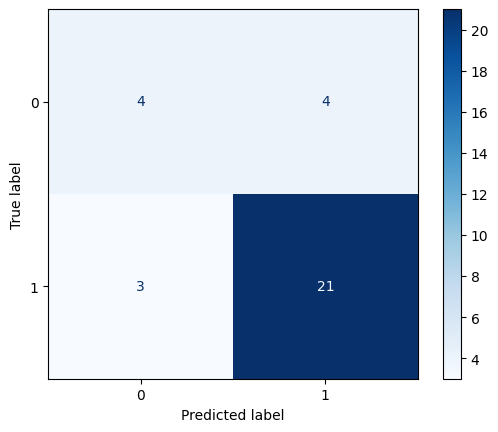

In [38]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [39]:
score = f1_score(y_test, y_pred, average='macro')
name = f"limit-f1-{score:2f}"
with open(os.path.join(SAVE_PATH, fr"{name}.pkl"), "wb") as fout:
    pickle.dump(model, fout)
print(f"Saved {name}.pkl")

Saved limit-f1-0.695238.pkl


In [40]:
with open(os.path.join(SAVE_PATH, f"{name}-feature.json"), "w") as fout:
    json.dump(list(cols), fout, indent=2)